In [1]:
!pip install numpyro

     |████████████████████████████████| 283 kB 4.1 MB/s 


# Imports

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

import numpyro
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

import jax
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
from jax import lax

import time

# fix MCMCndom generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

## Zeros for missing days

In [4]:
df0 = pd.read_csv("https://raw.githubusercontent.com/PriceTT/DSND-Capstone/master/permeate_data.csv")
df0.rename(columns={'sample_created_date': 'date'},inplace=True, errors='raise')

df0['date'] = pd.to_datetime(df0['date'], errors='coerce', infer_datetime_format=True).dt.date
min_date = df0.date.min()
max_date = df0.date.max()
print("min_date", min_date)
print("max_date", max_date)

df0.set_index("date",inplace=True)

dtr = pd.date_range(min_date, max_date, freq='D')
s = pd.Series(index=dtr)
df0 = pd.concat([df0, s[~s.index.isin(df0.index)]]).sort_index()
df0 = df0.drop([0],axis=1)
df0 = df0.interpolate()


# x = {"date":["3/1/16","5/1/16","5/1/16"], "score":[4,5,6]}
# df = pd.DataFrame.from_dict(x)
# df["date"] = pd.to_datetime(df["date"], format='%d/%m/%y')
# df.set_index("date",inplace=True)

# dtr =pd.date_range('01.01.2016', '01.10.2016', freq='D')
# s = pd.Series(index=dtr)
# df = pd.concat([df,s[~s.index.isin(df.index)]]).sort_index()
# df = df.drop([0],axis=1).fillna(0)

# print(df)

min_date 2009-07-08
max_date 2019-10-02


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/pandas/core/indexes/base.py:1963: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return self._engine.is_monotonic_increasing
/usr/local/lib/python3.7/dist-packages/pandas/core/sorting.py:403: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  indexer = non_nan_idx[non_nans.argsort(kind=kind)]


In [5]:
print("df0.shape", df0.shape)

df0.shape (4491, 1)


In [6]:
def compute_error(trues, predicted):
    import numpy
    corr = numpy.corrcoef(predicted, trues)[0,1]
    mae = numpy.mean(np.abs(predicted - trues))
    rae = numpy.sum(numpy.abs(predicted - trues)) / numpy.sum(numpy.abs(trues - numpy.mean(trues)))
    rmse = numpy.sqrt(numpy.mean((predicted - trues)**2))
    r2 = max(0, 1 - numpy.sum((trues-predicted)**2) / numpy.sum((trues - numpy.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [7]:
# corr, mae, rae, rmse, r2 = compute_error(y_mis, y_hat)
# print("CorrCoef: %.3f\nMAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (corr, mae, rmse, r2))

## AutoRegressive

# AR2

In [17]:
# convert data to a matrix
y = df0.values
N, D = y.shape
print("N=%d, D=%d" % (N,D))

ix_train = range(0, 3500)
ix_test = range(3500, 4491)
N_train = len(ix_train)
N_test = len(ix_test)
print("N_train:", N_train)
print("N_test:", N_test)
y_train = y[ix_train,:]
y_test = y[ix_test,:]

N=4491, D=1
N_train: 3500
N_test: 991


In [18]:
print("y_test.shape", y_test.shape)
print("ix_test", ix_test)

y_test.shape (991, 1)
ix_test range(3500, 4491)


In [19]:
#OK
def f_without_noise(carry, x=None):
  beta1, beta2, z_prev1, z_prev2 = carry
  z_t = beta1*z_prev1 + beta2*z_prev2
  z_prev1 = z_prev2
  z_prev2 = z_t
  return (beta1, beta2, z_prev1, z_prev2), z_t

In [20]:
#OK
beta1 = beta2 = 1.
z_prev1 = z_prev2 = 1.
carry = (beta1, beta2, z_prev1, z_prev2)
carry_updated, z_t = f_without_noise(carry, x=None) # propagating the dynamics forward for 1 time step
print("Initial carried items: \nbeta1: {}, beta2: {}, z_prev1: {}, z_prev2: {}".format(carry[0], carry[1], carry[2], carry[3]))
print("Updated carried items: \nbeta1: {}, beta2: {}, z_prev1: {}, z_prev2: {}".format(carry_updated[0], carry_updated[1], carry_updated[2], carry_updated[3]))
print("Computed z_t: {}".format(z_t))

Initial carried items: 
beta1: 1.0, beta2: 1.0, z_prev1: 1.0, z_prev2: 1.0
Updated carried items: 
beta1: 1.0, beta2: 1.0, z_prev1: 1.0, z_prev2: 2.0
Computed z_t: 2.0


In [21]:
#OK
def f(carry, noise_t):
    beta1, beta2, z_prev1, z_prev2, tau = carry
    z_t = beta1*z_prev1 + beta2*z_prev2 + tau*noise_t
    z_prev1 = z_prev2
    z_prev2 = z_t
    return (beta1, beta2, z_prev1, z_prev2, tau), z_t

In [64]:
def model_ar2(T, T_forecast, obs=None):
    """ Define priors over beta1, beta2, tau, noises, sigma, z_prev1 and z_prev2 (keep the shapes in mind)
    # Your code here
    """
    beta1 = numpyro.sample(name="beta_1", fn=dist.Normal(loc=0., scale=1.))
    beta2 = numpyro.sample(name="beta_2", fn=dist.Normal(loc=0., scale=1.))
    tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=3.))
    noises = numpyro.sample("noises", fn=dist.Normal(0., 0.1), sample_shape=(T+T_forecast-2,))
    sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=3.))
    z_prev1 = numpyro.sample(name="z_1", fn=dist.Beta(1., 3.))
    z_prev2 = numpyro.sample(name="z_2", fn=dist.Beta(1., 3.))
    
    """ Propagate the dynamics forward using jax.lax.scan
    carry = (beta1, beta2, z_prev1, z_prev2, tau)
    z_collection = [z_prev1, z_prev2]
    # Your code here
    """
    carry = (beta1, beta2, z_prev1, z_prev2, tau)
    z_collection = [z_prev1, z_prev2]
    carry, zs_exp = lax.scan(f, carry, noises, T+T_forecast-2)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)
    
    """ Sample the observed_y (y_obs) and predicted_y (y_pred) - note that you don't need a pyro.plate!
    # Your code here
    """
    numpyro.sample(name="y_obs", fn=dist.Normal(loc=z_collection[:T], scale=sigma), obs=obs[:T])
    numpyro.sample(name="y_pred", fn=dist.Normal(loc=z_collection[T:], scale=sigma), obs=None)
    return z_collection

In [65]:
from sklearn.model_selection import train_test_split

# X = df0['mean_value_scaled'][:2000].values
# y = df0['mean_value_scaled'][:2000].values

# X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3)
# N_train = len(X_train)
# N_test = len(X_test)

In [66]:
t0 = time.time()

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model=model_ar2, max_tree_depth=8, step_size=5e-3, adapt_step_size=False)
mcmc = MCMC(nuts_kernel, num_samples=3000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=N_train, T_forecast=N_test, obs=y_train[:,0])

t_fin = time.time()

print("Total time: {0:.3f}m".format((t_fin - t0)/60))

sample: 100%|██████████| 4000/4000 [05:17<00:00, 12.61it/s, 255 steps of size 5.00e-03. acc. prob=0.99]


Total time: 5.375m


In [67]:
mcmc.print_summary()

Streaming output truncated to the last 5000 lines.
 noises[486]      0.07      0.06      0.07     -0.04      0.17    271.22      1.00
 noises[487]     -0.01      0.06     -0.01     -0.11      0.09    258.10      1.00
 noises[488]     -0.02      0.06     -0.02     -0.11      0.09    320.02      1.00
 noises[489]     -0.00      0.06     -0.00     -0.11      0.10    275.25      1.00
 noises[490]      0.17      0.06      0.17      0.06      0.26    188.51      1.00
 noises[491]     -0.11      0.06     -0.11     -0.22     -0.01    315.20      1.00
 noises[492]      0.02      0.07      0.02     -0.09      0.13    219.19      1.00
 noises[493]      0.06      0.06      0.06     -0.04      0.16    234.83      1.01
 noises[494]      0.09      0.06      0.09     -0.02      0.18    200.65      1.00
 noises[495]      0.10      0.06      0.10      0.01      0.20    259.50      1.00
 noises[496]      0.11      0.06      0.11      0.01      0.21    373.77      1.00
 noises[497]      0.11      0.06    

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


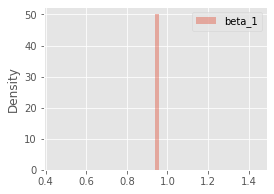

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


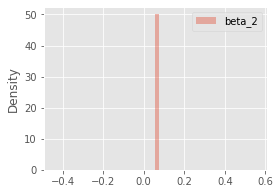

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


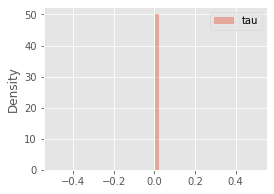

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


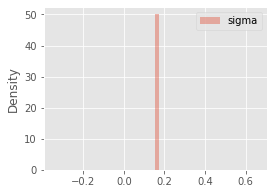

In [50]:
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}
nodes = ["beta_1", "beta_2", "tau", "sigma"]
for node in nodes:
  plt.figure(figsize=(4,3))
  sns.distplot(hmc_samples[node], label=node)
  plt.legend()
  plt.show()

In [51]:
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}
hmc_samples

{'beta_1': DeviceArray([0.9410326, 0.9410326, 0.9410326, ..., 0.9410326, 0.9410326,
              0.9410326], dtype=float32),
 'beta_2': DeviceArray([0.05786564, 0.05786564, 0.05786564, ..., 0.05786564,
              0.05786564, 0.05786564], dtype=float32),
 'noises': DeviceArray([[-0.5709307 , -0.13268298, -0.16466676, ...,  0.10090438,
                1.4879911 , -0.46896407],
              [-0.5709307 , -0.13268298, -0.16466676, ...,  0.10090438,
                1.4879911 , -0.46896407],
              [-0.5709307 , -0.13268298, -0.16466676, ...,  0.10090438,
                1.4879911 , -0.46896407],
              ...,
              [-0.5709307 , -0.13268298, -0.16466676, ...,  0.10090438,
                1.4879911 , -0.46896407],
              [-0.5709307 , -0.13268298, -0.16466676, ...,  0.10090438,
                1.4879911 , -0.46896407],
              [-0.5709307 , -0.13268298, -0.16466676, ...,  0.10090438,
                1.4879911 , -0.46896407]], dtype=float32),
 'sigma': De

In [52]:
q = hmc_samples["y_pred"]
q_mean = q.mean(axis=0).reshape(-1,)
q_std = q.std(axis=0).reshape(-1,)
y_pred_025 = q_mean - 2.96*q_std
y_pred_975 = q_mean + 2.96*q_std
y_pred_mean = q_mean

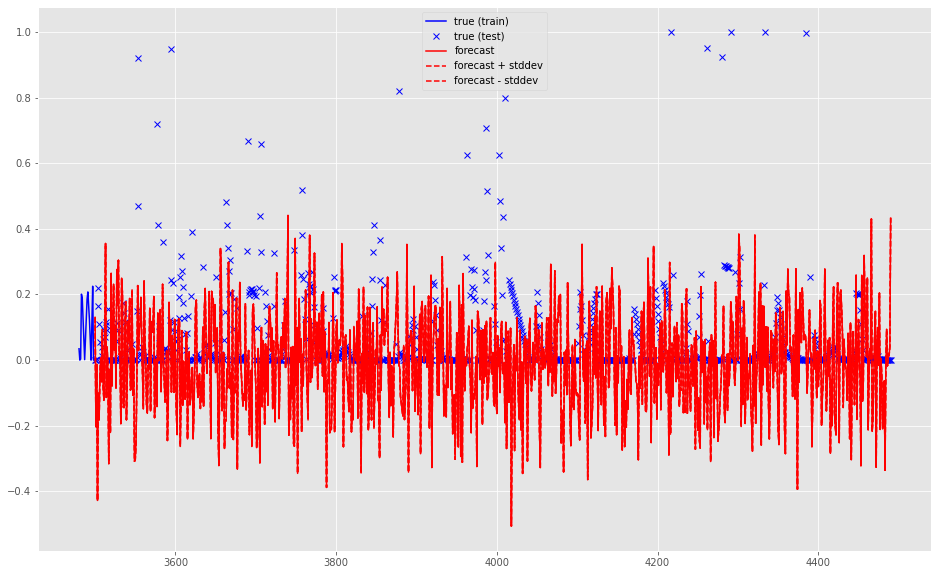

In [53]:
plt.plot(ix_train[-20:], y_train[-20:], "b-")
plt.plot(ix_test, y_test, "bx")
plt.plot(ix_test, y_pred_mean, "r-")
plt.plot(ix_test, y_pred_025, "r--")
plt.plot(ix_test, y_pred_975, "r--")
plt.fill_between(ix_test, y_pred_025, y_pred_975, alpha=0.3)
plt.legend(["true (train)","true (test)","forecast","forecast + stddev","forecast - stddev"])
plt.show()



# AR1

In [ ]:
# def f(carry, noise_t):
#     beta, z_prev, tau = carry
#     z_t = beta*z_prev + tau*noise_t
#     z_prev = z_t
#     return (beta, z_prev, tau), z_t

In [ ]:
# def model_ar1(T, T_forecast, obs=None, ix_mis=None, ix_obs=None):
#     # Define priors over beta, tau, noises, sigma, z_1 (keep the shapes in mind)
#     beta = numpyro.sample(name="beta", fn=dist.Normal(loc=0., scale=1))
#     tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=.1))
#     noises = numpyro.sample("noises", fn=dist.Normal(0, 1.), sample_shape=(T+T_forecast-1,))
#     sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=.1))
#     z_prev = numpyro.sample(name="z_1", fn=dist.Normal(loc=0, scale=.1))

#     # Propagate the dynamics forward using jax.lax.scan
#     carry = (beta, z_prev, tau)
#     z_collection = [z_prev]
#     carry, zs_exp = lax.scan(f, carry, noises, T+T_forecast-1)
#     z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)
    
#     # Sample the observed y (y_obs) and missing y (y_mis)
#     numpyro.sample(name="y_mis", fn=dist.Normal(loc=z_collection[ix_mis], scale=sigma), obs=None)
#     numpyro.sample(name="y_obs", fn=dist.Normal(loc=z_collection[ix_obs], scale=sigma), obs=obs[ix_obs])
#     return z_collection

In [ ]:
# t0 = time.time()

# rng_key = random.PRNGKey(0)
# rng_key, rng_key_ = random.split(rng_key)

# nuts_kernel = NUTS(model=model_ar1)
# mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000, num_chains=1)
# mcmc.run(rng_key_, T=N_train, T_forecast=N_test, obs=y_train, ix_mis=idx_mis, ix_obs=idx_obs)

# t_fin = time.time()

# print("Total time: {0:.3f}m".format((t_fin - t0)/60))